In [67]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score as ss
import itertools
from adjustText import adjust_text  

# Estudio de la dependencia de combustibles fosiles
## ¿De que fuentes proviene la electricidad que consume cada pais?

La electricidad obtenida a partir de fuentes energeticas fosiles (gas, petroleo y carbon) conlleva un aumento en las emisiones de gases de efecto invernadero como el dioxido de carbono, fuertemente implicados en el cambio climatico global. <br>
Tanto las fuentes renovables (solar, eolica e hidroelectrica) como la nuclear son consideradas bajas en carbono ya que no aumentan las emisiones de dioxido de carbono. <br>
En el marco de los esfuerzos globales por reducir el impacto ambiental y la huella de carbono, se han firmado acuerdos internacionales que comprometen a los paises en buscar una transicion energetica que permita reducir la dependencia de energias de origen fosil. <br>
En este informe buscamos evaluar el nivel de dependencia de combustibles fosiles para electricidad de cada pais del mundo, agrupandolos segun las fuentes de las que provienen la electricidad que consumen.

### **Objetivo:** Evaluar el nivel de dependencia de combustibles fosiles para electricidad de cada pais del mundo <br>
Se toman los datos promedio para cada pais entre los años de 2010 a 2020 (para mas detalles ver notebook limpieza_procesamiento_cem).<br>
Se corre un modelo no supervisado usando un algoritmo DBSCAN. 

## 1. Importación y visualización de datos

Importamos el dataset. 

In [68]:
df = pd.read_csv(r"../datasets/wec_ns.csv")
df.head(5)

,country,population,low_carbon_share_elec,fossil_share_elec,renewables_share_elec,nuclear_share_elec,fossil_cons_per_capita,per_capita_electricity,continente,iso_code
0,Afghanistan,34.247333,83.543444,16.456556,83.543444,0.0,5.156111,31.813000,Asia,AFG
1,Albania,2.896444,99.851444,0.148556,99.851444,0.0,2.103889,1998.432000,Europa,ALB
2,Algeria,39.784222,0.766333,99.233667,0.766333,0.0,1568.103333,1580.157222,África,DZA
3,American Samoa,0.055778,0.000000,100.000000,0.000000,0.0,2888.744333,2888.744333,Oceanía,ASM
4,Angola,27.940556,65.673556,34.326444,65.673556,0.0,110.650000,326.007889,África,AGO


In [93]:
fig1 = px.scatter(x=df["fossil_share_elec"], y=df["renewables_share_elec"])
fig1.update_layout(
    xaxis_title="Porcentaje de fuente fosil",
    yaxis_title="Porcentaje de fuente renovable",
)

# Agregar título al gráfico
fig1.update_layout(
    title="Proporcion de electricidad de fuentes renovables vs fuentes fosiles ",
)

Aunque los puntos forman una recta, no nos interesa modelarlo como regresion lineal ya que conocemos la formula que siguen: <br> 
porcentaje fosil + porcentaje renovables + procentaje nuclear = 100. 

Por lo que es esperable que al aumentar, por ejemplo, el porcentaje de fuente renovable disminuya el porcentaje de fuente fosil, lo que lleva a la formacion de la recta que se observa en el grafico. Sin embargo, vemos tambien que algunos puntos se desvian de la recta. <br>

In [94]:
fig2 = px.scatter(x=df["nuclear_share_elec"], y=df["renewables_share_elec"])
fig2.update_layout(
    xaxis_title="Porcentaje de fuente nuclear",
    yaxis_title="Porcentaje de fuente renovable",
)

# Agregar título al gráfico
fig2.update_layout(
    title="Proporcion de electricidad de fuentes renovables vs fuente nuclear ",
)

Vemos que la mayoria de los paises aparecen como una recta vertical en el 0 del eje X: son aquellos paises que no consumen electricidad de fuentes nucleares. Vemos tambien que otros paises muestran diversos porcentajes de electricidad de fuente nuclear. 

Usaremos el algoritmo de clustering por DBSCAN para agrupar a los paises segun su distribucion de fuentes de electricidad. 

## 2. Función de optimización de DBSCAN

El siguiente codigo define una funcion que permite poner a prueba muchos modelos de DBSCAN con distintos parametros y calcular su score de silhouette para hallar la combinacion de parametros que devuelve el modelo con score maximo. 

Primero especificamos las combinaciones de epsilon y min_sample que queremos probar.  

In [71]:
epsilons = np.linspace(0.01, 1, num=30)
epsilons

array([0.01      , 0.04413793, 0.07827586, 0.11241379, 0.14655172,
       0.18068966, 0.21482759, 0.24896552, 0.28310345, 0.31724138,
       0.35137931, 0.38551724, 0.41965517, 0.4537931 , 0.48793103,
       0.52206897, 0.5562069 , 0.59034483, 0.62448276, 0.65862069,
       0.69275862, 0.72689655, 0.76103448, 0.79517241, 0.82931034,
       0.86344828, 0.89758621, 0.93172414, 0.96586207, 1.        ])

In [72]:
min_samples = np.arange(2, 20, step=1)
min_samples

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])

In [73]:
combinations = list(itertools.product(epsilons, min_samples))

Cantidad de combinaciones de parametros que se van a probar:

In [75]:
N = len(combinations)
print(f"Se pondran a prueba {N} combinaciones de {len(epsilons)} valores de epsilon y {len(min_samples)} valores de min_samples.")

Se pondran a prueba 540 combinaciones de 30 valores de epsilon y 18 valores de min_samples.


Definimos la funcion:

In [103]:
def get_scores_and_labels(combinations, X):
  ''' Calcula parametros optimos de DBSCAN para maximixar score de silhouette. 
  combinations: lista de combinaciones de epsilons y min_samples a probar. 
  X: numpy.array de variables a modelar. 
  '''
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)
    if -1 in labels_set:
      num_clusters -= 1

    if (num_clusters < 2) or (num_clusters > 50):
      scores.append(-10)
      all_labels_list.append('bad')
      c = (eps, num_samples)
      print(f"Combination {c} on iteration {i+1} of {N} has {num_clusters} clusters. Moving on")
      continue

    scores.append(ss(X, labels))
    all_labels_list.append(labels)
    print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'epsilon_optimo': best_parameters[0],
          'min_samples_optimo': best_parameters[1],
          'etiquetas_optimas': best_labels,
          'score_maximo': best_score}



## 3. Modelo

Creamos una variable con las columnas de interes. 

In [77]:
features = ["fossil_share_elec", "renewables_share_elec","nuclear_share_elec"]
X = df[features]
X.head(5)

,fossil_share_elec,renewables_share_elec,nuclear_share_elec
0,16.456556,83.543444,0.0
1,0.148556,99.851444,0.0
2,99.233667,0.766333,0.0
3,100.000000,0.000000,0.0
4,34.326444,65.673556,0.0


Escalamos las variables para evitar que una tenga mas peso que otra simplemente por su magnitud.

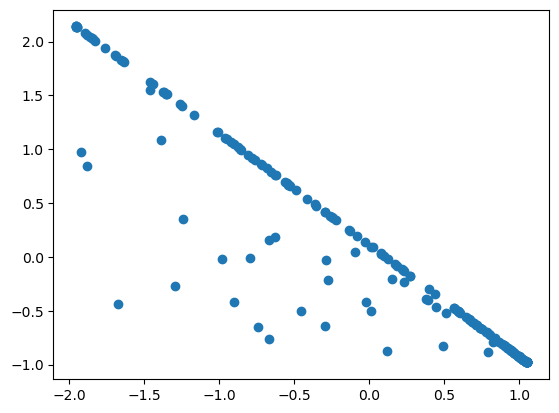

In [78]:
X_scaled = StandardScaler().fit_transform(X)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1])

Usamos la funcion `get_scores_and_labels()` para poner a prueba las distintas combinaciones de parametros y encontrar el modelo con mayor score. 

In [106]:
mejor_score = get_scores_and_labels(combinations, X_scaled)

Index: 0, Score: 0.10754848631983081, Labels: [-1  0  1  1 -1  2 -1 -1  3  3 -1 -1  1  1  2  2  2 -1  4  5  1  0 -1 -1
  1 -1  1  1 -1  6  7 -1 -1 -1  1  4  2 -1 -1 -1  5 -1  8 -1 -1 -1 -1 -1
  0 -1  1  9 -1 -1 -1 -1 10  5  3  0 11 -1 -1 -1 -1 -1  1 12 -1 11  1 13
  7  2 14  2 -1 15  2  2  6 -1  1 -1  0 -1 -1 -1 -1 -1  2 -1 16 -1 17 18
 12 18  1 19 -1 -1  5  0  1  1 -1 -1 20 19 14  1 -1 21  5 -1 -1 -1 -1 22
 23  1  6 -1 -1  1  0 -1  6 12 15  2 -1  1 -1 -1  1 -1  1 -1 10  0 -1 13
 14 -1 17  1 -1 -1 -1  1  5  1  2  6 -1 16  1  8 -1  1 24  5 -1 -1 -1  5
 -1 -1  1 -1 -1 24 20 -1 -1 21 -1 -1 -1 14 -1  1  1  5  9  1  1 -1 -1  1
 -1 -1  1 -1 -1  6 -1 -1 22 -1 23], NumClusters: 25
Index: 1, Score: -0.0487341541392844, Labels: [-1  0  1  1 -1  2 -1 -1  3  3 -1 -1  1  1  2  2  2 -1 -1  4  1  0 -1 -1
  1 -1  1  1 -1  5 -1 -1 -1 -1  1 -1  2 -1 -1 -1  4 -1 -1 -1 -1 -1 -1 -1
  0 -1  1 -1 -1 -1 -1 -1 -1  4  3  0 -1 -1 -1 -1 -1 -1  1  6 -1 -1  1 -1
 -1  2  7  2 -1 -1  2  2  5 -1  1 -1  0 -1 -1 -1 -1 -

In [107]:
mejor_score

{'epsilon_optimo': 0.14655172413793105,
 'min_samples_optimo': 5,
 'etiquetas_optimas': array([ 4,  0,  1,  1,  2,  1, -1, -1,  1,  1,  4,  1,  1,  1,  1,  1,  1,
        -1,  0,  1,  1,  0,  3,  3,  1, -1,  1,  1, -1,  1,  4,  3,  2, -1,
         1,  0,  1,  3, -1,  4,  1,  3,  1,  0,  2,  1,  1, -1,  0,  2,  1,
         3,  1,  2,  1,  2,  3,  1,  1,  0,  2, -1, -1,  2,  3,  3,  1,  4,
        -1,  2,  1,  3,  4,  1,  1,  1,  2,  2,  1,  1,  1,  2,  1, -1,  0,
        -1,  1,  1,  1,  3,  1,  3,  1, -1,  1,  1,  4,  1,  1,  0,  4,  2,
         1,  0,  1,  1,  2,  3,  3,  0,  1,  1,  2,  1,  1,  3, -1, -1,  1,
         1,  2,  1,  1,  0,  0,  1,  0, -1,  1,  4,  2,  1, -1,  1,  4,  0,
         1, -1,  1,  2,  3,  0,  2,  3,  1,  2,  1,  1, -1, -1,  2,  1,  1,
         1,  1,  1,  3,  1,  1,  1,  3,  1,  2,  1, -1, -1,  1,  1, -1, -1,
         1, -1,  3,  2,  3, -1, -1,  1, -1,  0,  3,  1,  3,  1,  1,  1,  3,
         1,  1,  0, -1,  1, -1, -1,  1,  0,  1,  1,  2,  3,  1,  0,  2],
    

Encontramos los parametros que generan el modelo con mayor score. 

## 4. Identificacion de clusters

In [108]:
df['cluster'] = mejor_score['etiquetas_optimas']

df['cluster'].value_counts()

cluster
 1    91
-1    32
 2    25
 3    25
 0    20
 4    10
Name: count, dtype: int64

In [82]:
cluster0 = df.loc[df["cluster"] == 0, "country"]
cluster0

1                           Albania
18                           Belize
21                           Bhutan
35         Central African Republic
43                       Costa Rica
48     Democratic Republic of Congo
59                         Ethiopia
84                          Iceland
99                       Kyrgyzstan
103                         Lesotho
109                          Malawi
123                      Mozambique
124                         Namibia
126                           Nepal
135                          Norway
141                        Paraguay
179                      Tajikistan
189                          Uganda
195                         Uruguay
201                          Zambia
Name: country, dtype: object

In [83]:
cluster1 = df.loc[df["cluster"] == 1, "country"]
cluster1

2                               Algeria
3                        American Samoa
5                   Antigua and Barbuda
8                                 Aruba
9                             Australia
11                           Azerbaijan
12                              Bahamas
13                              Bahrain
14                           Bangladesh
15                             Barbados
16                              Belarus
19                                Benin
20                              Bermuda
24                             Botswana
26               British Virgin Islands
27                               Brunei
29                         Burkina Faso
34                       Cayman Islands
36                                 Chad
40                              Comoros
42                         Cook Islands
45                                 Cuba
46                               Cyprus
50                             Djibouti
52                   Dominican Republic


In [84]:
cluster2 = df.loc[df["cluster"] == 2, "country"]
cluster2

4             Angola
32          Cameroon
44           Croatia
49           Denmark
53           Ecuador
55       El Salvador
60              Fiji
63     French Guiana
69             Ghana
76         Guatemala
77            Guinea
81          Honduras
101           Latvia
106        Lithuania
112             Mali
120       Montenegro
130        Nicaragua
139           Panama
142             Peru
145         Portugal
150           Rwanda
162     Sierra Leone
173            Sudan
198        Venezuela
202         Zimbabwe
Name: country, dtype: object

In [92]:
no_agrup = df.loc[df["cluster"] == -1, "country"]
no_agrup

6           Argentina
7             Armenia
17            Belgium
25             Brazil
28           Bulgaria
33             Canada
38              China
47            Czechia
61            Finland
62             France
68            Germany
83            Hungary
85              India
93              Japan
116         Mauritius
117            Mexico
127       Netherlands
132           Nigeria
137          Pakistan
148           Romania
149            Russia
164          Slovakia
165          Slovenia
168      South Africa
169       South Korea
171             Spain
175            Sweden
176       Switzerland
178            Taiwan
190           Ukraine
192    United Kingdom
193     United States
Name: country, dtype: object

## 5. Visualizacion de clusters

In [109]:
fig = px.scatter(x=df["fossil_share_elec"], y=df["renewables_share_elec"], color=df['cluster'])
fig.update_layout(
    xaxis_title="Porcentaje de fuente fosil",
    yaxis_title="Porcentaje de fuente renovable"
    
)

# Filtrar las etiquetas de texto para mostrar solo para Sudamérica
# fig.update_traces(text=suram['country'])

# Agregar título al gráfico
fig.update_layout(
    title="Proporcion de electricidad de fuentes renovables vs fuentes fosiles",
)
fig.show()





Podemos agrupar los paises del mundo segun su dependencia de las fuentes fosiles para electricidad. <br>
Magenta (cluster0) --> totalmente dependiente de fuentes fosiles <br>
Naranja (cluster4) --> fuertemente dependiente de fuentes fosiles <br>
Rojo (cluster2) --> moderadamente dependiente de fuentes fosiles <br>
Amarillo (cluster3) --> levemente dependiente de fuentes fosiles <br>
Violeta (cluster1) --> en camino a independencia de fuentes fosiles<br>

In [129]:
fig = px.scatter(x=df["nuclear_share_elec"], y=df["renewables_share_elec"], color=df['cluster'])
fig.update_layout(
    xaxis_title="Porcentaje de fuente nuclear",
    yaxis_title="Porcentaje de fuente renovable",
)

# Agregar título al gráfico
fig.update_layout(
    title="Proporcion de electricidad de fuentes renovables vs fuente nuclear",
)
fig.show()

### Paises no agrupados: "cluster -1" 

Los paises ubicados en el cluster -1 corresponden a aquellos que no han podido ser incluidos en ningun otro cluster. Estos puntos formarian entonces parte del "ruido" del modelo. Sin embargo, al observar la forma particular de los datos, vemos que los que no han podido ser agrupados corresponden a los puntos que se desvian de la recta, que son los paises que obtienen cierto porcentaje de su consumo electrico de fuentes nucleares. <br>
Esto podemos corroborarlo observando el grafico de Proporcion de electricidad de fuentes renovables vs fuente nuclear. Asimismo, a continuacion se muestra que de los 15 paises con mayor porcentaje de electricidad de fuente nuclear, todos fueron asignados al cluster -1. 

In [88]:
df.sort_values("nuclear_share_elec").tail(15)

,country,population,low_carbon_share_elec,fossil_share_elec,renewables_share_elec,nuclear_share_elec,fossil_cons_per_capita,per_capita_electricity,continente,iso_code,cluster
192,United Kingdom,65.834556,44.084700,55.915300,24.5374,19.547400,2894.729900,5114.452200,Europa,GBR,-1
171,Spain,46.804333,57.311600,42.688400,36.3737,20.938000,2533.461000,5918.852400,Europa,ESP,-1
169,South Korea,50.677778,30.937400,69.062600,3.2709,27.666300,7121.353000,10310.270200,Asia,KOR,-1
7,Armenia,2.920889,61.522333,38.477667,31.0180,30.504444,962.868444,2498.783333,Asia,ARM,-1
61,Finland,5.472222,76.270900,23.729100,42.6600,33.610900,3015.997500,12615.648700,Europa,FIN,-1
47,Czechia,10.615778,44.833600,55.166400,10.7191,34.114600,4402.079900,7977.105300,Europa,CZE,-1
28,Bulgaria,7.195000,50.194600,49.805400,15.3273,34.867400,3169.401300,6346.629700,Europa,BGR,-1
176,Switzerland,8.275556,98.881300,1.118700,62.5076,36.373700,87.178500,7826.662900,Europa,CHE,-1
165,Slovenia,2.068556,67.632200,32.367800,30.9135,36.718600,2505.846100,7762.003600,Europa,SVN,-1
175,Sweden,9.759333,97.630400,2.369600,58.5124,39.118200,387.715700,16394.511200,Europa,SWE,-1


### En Sudamérica:

In [89]:
suram = df[df["continente"] == "Sudamérica"]

In [122]:
suram.sort_values("nuclear_share_elec").drop(["low_carbon_share_elec", "fossil_cons_per_capita", "continente", "iso_code", "per_capita_electricity"],axis=1)

,country,population,fossil_share_elec,renewables_share_elec,nuclear_share_elec,cluster
22,Bolivia,10.866778,68.279000,31.721000,0.0000,3
37,Chile,18.032667,56.297100,43.702900,0.0000,3
39,Colombia,47.756444,26.210300,73.789700,0.0000,4
53,Ecuador,16.258111,38.180889,61.819111,0.0000,2
63,French Guiana,0.262667,39.605667,60.394333,0.0000,2
79,Guyana,0.767111,97.984000,2.016000,0.0000,1
141,Paraguay,6.689000,0.003889,99.996111,0.0000,0
142,Peru,30.663889,42.250600,57.749400,0.0000,2
174,Suriname,0.558667,55.224222,44.775778,0.0000,3
184,Trinidad and Tobago,1.368222,99.948778,0.051222,0.0000,1


A continuacion graficamos todos los paises del mundo y destacamos la posicion de los paises de sudamerica, para observarlos en el panorama mundial. 

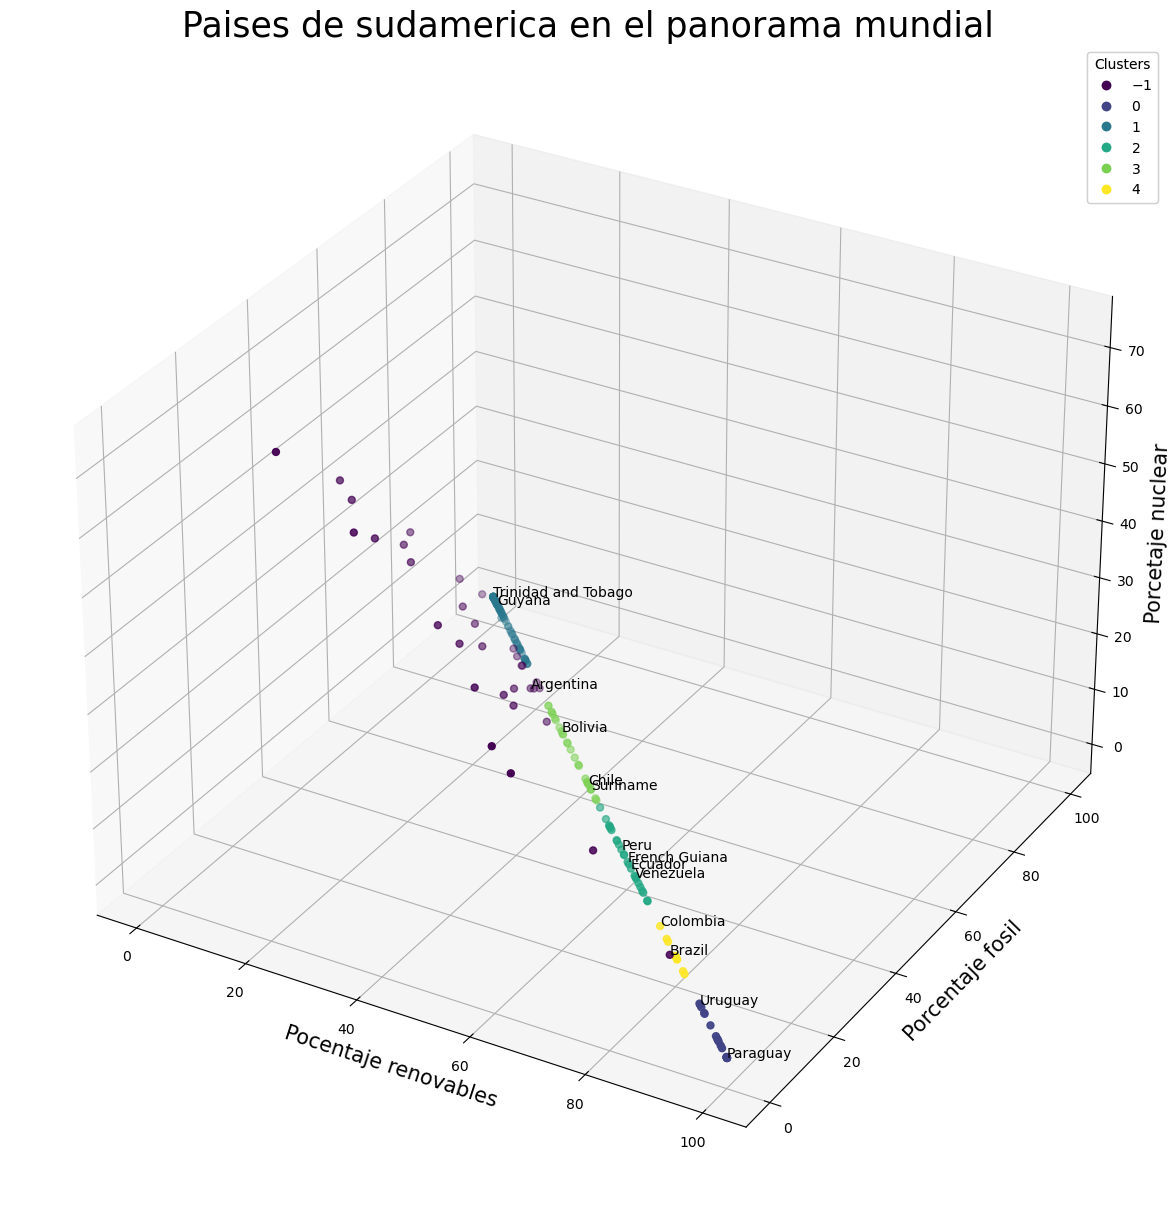

In [91]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['renewables_share_elec'], df['fossil_share_elec'], df['nuclear_share_elec'],
                     c=df['cluster'], cmap='viridis', s=25)

# Iterar a través de cada punto y agregar el texto correspondiente
for country, x, y, z in zip(suram['country'], suram['renewables_share_elec'], suram['fossil_share_elec'], suram['nuclear_share_elec']):
    ax.text(x, y, z, country, fontsize=10)


ax.set_xlabel('Pocentaje renovables', fontsize=15)
ax.set_ylabel('Porcentaje fosil', fontsize=15)
ax.set_zlabel('Porcetaje nuclear', fontsize=15)
ax.set_title('Paises de sudamerica en el panorama mundial', fontsize=25)

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()


Observamos que los paises de Sudamerica presentan diversidad de perfiles energeticos, con paises agrupados en cada uno de los clusters arrojados por el modelo. En un extremo, paises como Paraguay y Uruguay muestran gran independencia de los combustibles fosiles para electricidad. En el otro, paises como Trinidad y Tobago y Granada muestran total dependencia de los combustibles fosiles. 

Argentina se ubica en el cluster -1. Desarrollo incipiente de energia nuclear para electricidad. 

## 6. Conclusiones

Podemos concluir que el algoritmo de DBSCAN nos permitio agrupar a los paises del mundo segun las distintas fuentes de las que obtienen electricidad para abastecer de electricidad a la poblacion y la industria. 
<br> - Este agrupamiento arroja informacion sobre el nivel de dependencia que tiene cada pais de las fuentes fosiles, pudiendo ir desde fuertemente dependiente hasta virtualmente independiente de las mismas. 
<br> - Las mayoria de los paises que esta en camino a lograr independencia de las fuentes fosiles lo logra a traves de las fuentes de electricidad renovables (hidroelectrica, solar, eolica, etc) mientras que algunos pocos paises lo logran a traves de la electricidad de fuente nuclear. 


Es importante destacar que la electricidad consumida por un pais es solo una parte de su consumo energetico total, que tambien comprende el consumo de energia para transporte (mayoritariamente combustibles como nafta, gas y gasoil) y calefaccion (que incluye combustibles como gas y kerosene). Los consumos para transporte y calefaccion son mas dificiles de independizar de fuentes fosiles que el consumo para electricidad, por lo que debe considerarse el perfil energetico completo para sacar conclusiones sobre el nivel integral de dependencia de fuentes fosiles de cada pais. 